In [1]:
import numpy as np
import mne
%matplotlib notebook
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import json
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA,FastICA
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from scipy.fftpack import fft,ifft
import math
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from scipy.signal import spectrogram
from mne.preprocessing.ica import ICA,run_ica,create_ecg_epochs


C:\Anaconda3\lib\site-packages\pandas\__init__.py:7: DeprecationWarning: bad escape \s
  from pandas import hashtable, tslib, lib
C:\Anaconda3\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)
C:\Anaconda3\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)


In [2]:
os.chdir('C:/Users/ning/Downloads/training set')
print(os.listdir(os.getcwd()))
directoryList = os.listdir(os.getcwd())

['64chlocs.elp', 'label_extraction.npy', 'label_extraction.pkl', 's5d2_final.edf', 's5d2_final_annotations.txt', 's6n2_final.edf', 's6n2_final_annotations.txt', 'Sleep Stage Scoring Criteria.docx', 'suj10_d1final.edf', 'suj10_d1final_annotations.txt', 'suj10_d2final.edf', 'suj10_d2final_annotations.txt', 'suj5_d1final.edf', 'suj5_d1final_annotations.txt', 'suj6_d1final.edf', 'suj6_d1final_annotations.txt', 'suj8_d1final.edf', 'suj8_d1final_annotations.txt', 'suj8_d2final.edf', 'suj8_d2final_annotations.txt', 'suj9_d1final.edf', 'suj9_d1final_annotations.txt', 'suj9_d2final.edf', 'suj9_d2final_annotations.txt', 'Training Data Frame']


In [3]:
EDFFind = re.compile("edf", re.IGNORECASE);EDFfiles=[]
TXTFind = re.compile("txt",re.IGNORECASE);TXTfiles=[]
for item in directoryList:
    if EDFFind.search(item):
        EDFfiles.append(item)
    elif TXTFind.search(item):
        TXTfiles.append(item)

In [4]:
def pick_sample_file(EDFfiles,n=0):
    file_to_read=EDFfiles[n]
    fileName = file_to_read.split('.')[0]
    return file_to_read,fileName
def load_data(file_to_read):
    """ not just the data, but also remove artifact by using mne.ICA"""
    raw = mne.io.read_raw_edf(file_to_read,stim_channel=None,preload=True)
    return raw
def dictionary_for_target_channels(channelList,raw):
    channel_index=[]
    for channelNames in channelList:
        channel_index.append(list(raw.ch_names).index(channelNames))
    return channel_index, channelList
def annotation_to_labels(TXTfiles,sample_number=0,label='markon',last_letter=-1):
    annotation_to_read=[x for x in TXTfiles if fileName in x]
    file = pd.read_csv(annotation_to_read[0])
    file['Duration'] = file['Duration'].fillna(0)
    labelFind = re.compile(label,re.IGNORECASE)
    windowLabel=[];cnt=1
    for row in file.iterrows():
        currentEvent = row[1][-1]
        if (labelFind.search(currentEvent)):
            if last_letter==-1:
                windowLabel.append(currentEvent[-1])
            else:
                windowLabel.append(currentEvent)
    return windowLabel
def relabel_to_binary(windowLabel,label='2'):
    YLabel=[]
    for row in windowLabel:
        if row[0] == label:
            YLabel.append(1)
        else:
            YLabel.append(0)
    return YLabel
unit_step=lambda x:0 if x<0 else 1
def structure_to_data(channelList,YLabel,raw,sample_points=100):
    data={}
    for channel_names in channelList:
        data[channel_names]=[]
    data['label']=[]
    channel_index,_=dictionary_for_target_channels(channelList,raw)
    for sample in range(len(YLabel)):
        
        try:
            startPoint=30*sample;endPoint=30*(sample+1)
            start,stop=raw.time_as_index([startPoint,endPoint])
            segment,time=raw[channel_index,start:stop]
            
            for idx,channel_names in enumerate(channelList):
                yf = fft(segment[idx,:]);N=sample_points
                data[channel_names].append(np.abs(yf[0:N]))
            data['label'].append(YLabel[sample])
        except:
            print('last window is missing due to error')
            pass
    return data
def merge_dicts(dict1,dict2):
    for key, value in dict2.items():
        dict1.setdefault(key,[]).extend(value)
    return dict1

def logistic_func(theta, x):
    return 1./(1+np.exp(x.dot(theta)))
def log_gradient(theta, x, y):
    first_calc = logistic_func(theta, x) - np.squeeze(y)
    final_calc = first_calc.T.dot(x)
    return final_calc
def cost_func(theta, x, y):
    log_func_v = logistic_func(theta,x)
    y = np.squeeze(y)
    step1 = y * np.log(log_func_v)
    step2 = (1-y) * np.log(1 - log_func_v)
    final = -step1 - step2
    return np.mean(final)
def grad_desc(theta_values, X, y, lr=10e-8, converge_change=10e-6):
    #normalize
    #X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    #setup cost iter
    cost_iter = []
    cost = cost_func(theta_values, X, y)
    cost_iter.append([0, cost])
    change_cost = 1
    i = 1
    while(change_cost > converge_change):
        old_cost = cost
        theta_values = theta_values - (lr * log_gradient(theta_values, X, y))
        cost = cost_func(theta_values, X, y)
        cost_iter.append([i, cost])
        change_cost = old_cost - cost
        i+=1;#print(i)
    return theta_values, np.array(cost_iter)
def pred_values(theta, X, hard=True,one_sample=False):
    #normalize
    if not one_sample:
        X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    pred_prob = logistic_func(theta, X)
    pred_value = np.where(pred_prob >= .5, 1, 0)
    if hard:
        return pred_value
    return pred_prob
def SK_to_data(channelList,markPairs,dataLabels,raw):
    data={}
    for channel_names in channelList:
        data[channel_names]=[]
    data['label']=[]
    channel_index,_=dictionary_for_target_channels(channelList,raw)
    for sample,pairs in enumerate(markPairs):
        #print(idx)
        
        start,stop = raw.time_as_index(pairs)
            
        segment,time=raw[channel_index,start:stop]
        try:    
            for idx,channel_names in enumerate(channelList):
                yf = fft(segment[idx,:]);N=100;#print(channel_names,N)
                data[channel_names].append(np.abs(yf[0:100]))
            data['label'].append(dataLabels[sample])
        except:
            continue
       
    return data
def annotation_file(TXTFiles,sample_number=0):
    annotation_to_read=[x for x in TXTfiles if fileName in x]
    file = pd.read_csv(annotation_to_read[0])
    file['Duration'] = file['Duration'].fillna(0)
    return file
def search_for_marks(file,duration=3,proprotion = 0.05):
    spindleFind = re.compile("spindle", re.IGNORECASE)
    complexFind = re.compile("complex",re.IGNORECASE)
    markPairs=[];dataLabels=[];eventCount=0
    for row in file.iterrows():
        curEvent=row[1][-1]
        if (spindleFind.search(curEvent) or complexFind.search(curEvent)):
            time = row[1][0]
            startTime = int(time - (duration*proprotion))
            endTime = int(time + (duration*(1-proprotion)))
            markPairs.append([startTime, endTime])
            if spindleFind.search(curEvent):
                dataLabels.append(0)
            if complexFind.search(curEvent):
                dataLabels.append(1)
            eventCount += 1
    return dataLabels,eventCount,markPairs
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
channelList=['F3','F4','C3','C4','O1','O2','ROC','LOC']
file_to_read,fileName = pick_sample_file(EDFfiles,n=0)
print(file_to_read)

s5d2_final.edf


In [6]:
raw=load_data(file_to_read)

Extracting edf Parameters from s5d2_final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 3383999  =      0.000 ...  3383.999 secs...
[done]
Ready.


In [7]:
raw.pick_channels(channelList)
picks=mne.pick_types(raw.info,meg=False,eeg=True,eog=False,stim=False)
raw.filter(5,50)

Band-pass filtering from 5 - 50 Hz


In [29]:
picks

array([0, 1, 2, 3, 4, 5, 6, 7])

In [15]:
ica = ICA(n_components=None, n_pca_components=None, max_pca_components=None,max_iter=1000,
          noise_cov=None, random_state=0)

In [16]:
ica.fit(raw,picks=picks,decim=3,reject=dict(mag=4e-12, grad=4000e-13))

Fitting ICA to data using 8 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 8


<ICA  |  raw data decomposition, fit (fastica): 1127897 samples, 8 components, channels used: "eeg">

In [20]:
ica.detect_artifacts(raw,start_find=None, stop_find=None, ecg_ch=None, ecg_score_func='pearsonr', 
                    eog_ch='ROC', eog_score_func='pearsonr', eog_criterion=0.2, skew_criterion=None, 
                     kurt_criterion=None, var_criterion=None,add_nodes=None)

    Searching for artifacts...
    found 3 artifacts by EOG 00
Artifact indices found:
    1, 7, 1, 6, 7
    Removing duplicate indices...
Ready.


<ICA  |  raw data decomposition, fit (fastica): 1127897 samples, 8 components, channels used: "eeg", 3 sources marked for exclusion>

In [23]:
eog_inds,scores=ica.find_bads_eog(raw,ch_name='ROC',threshold=0.99)

Using channel ROC as EOG channel
... filtering ICA sources
... filtering target


<IPython.core.display.Javascript object>


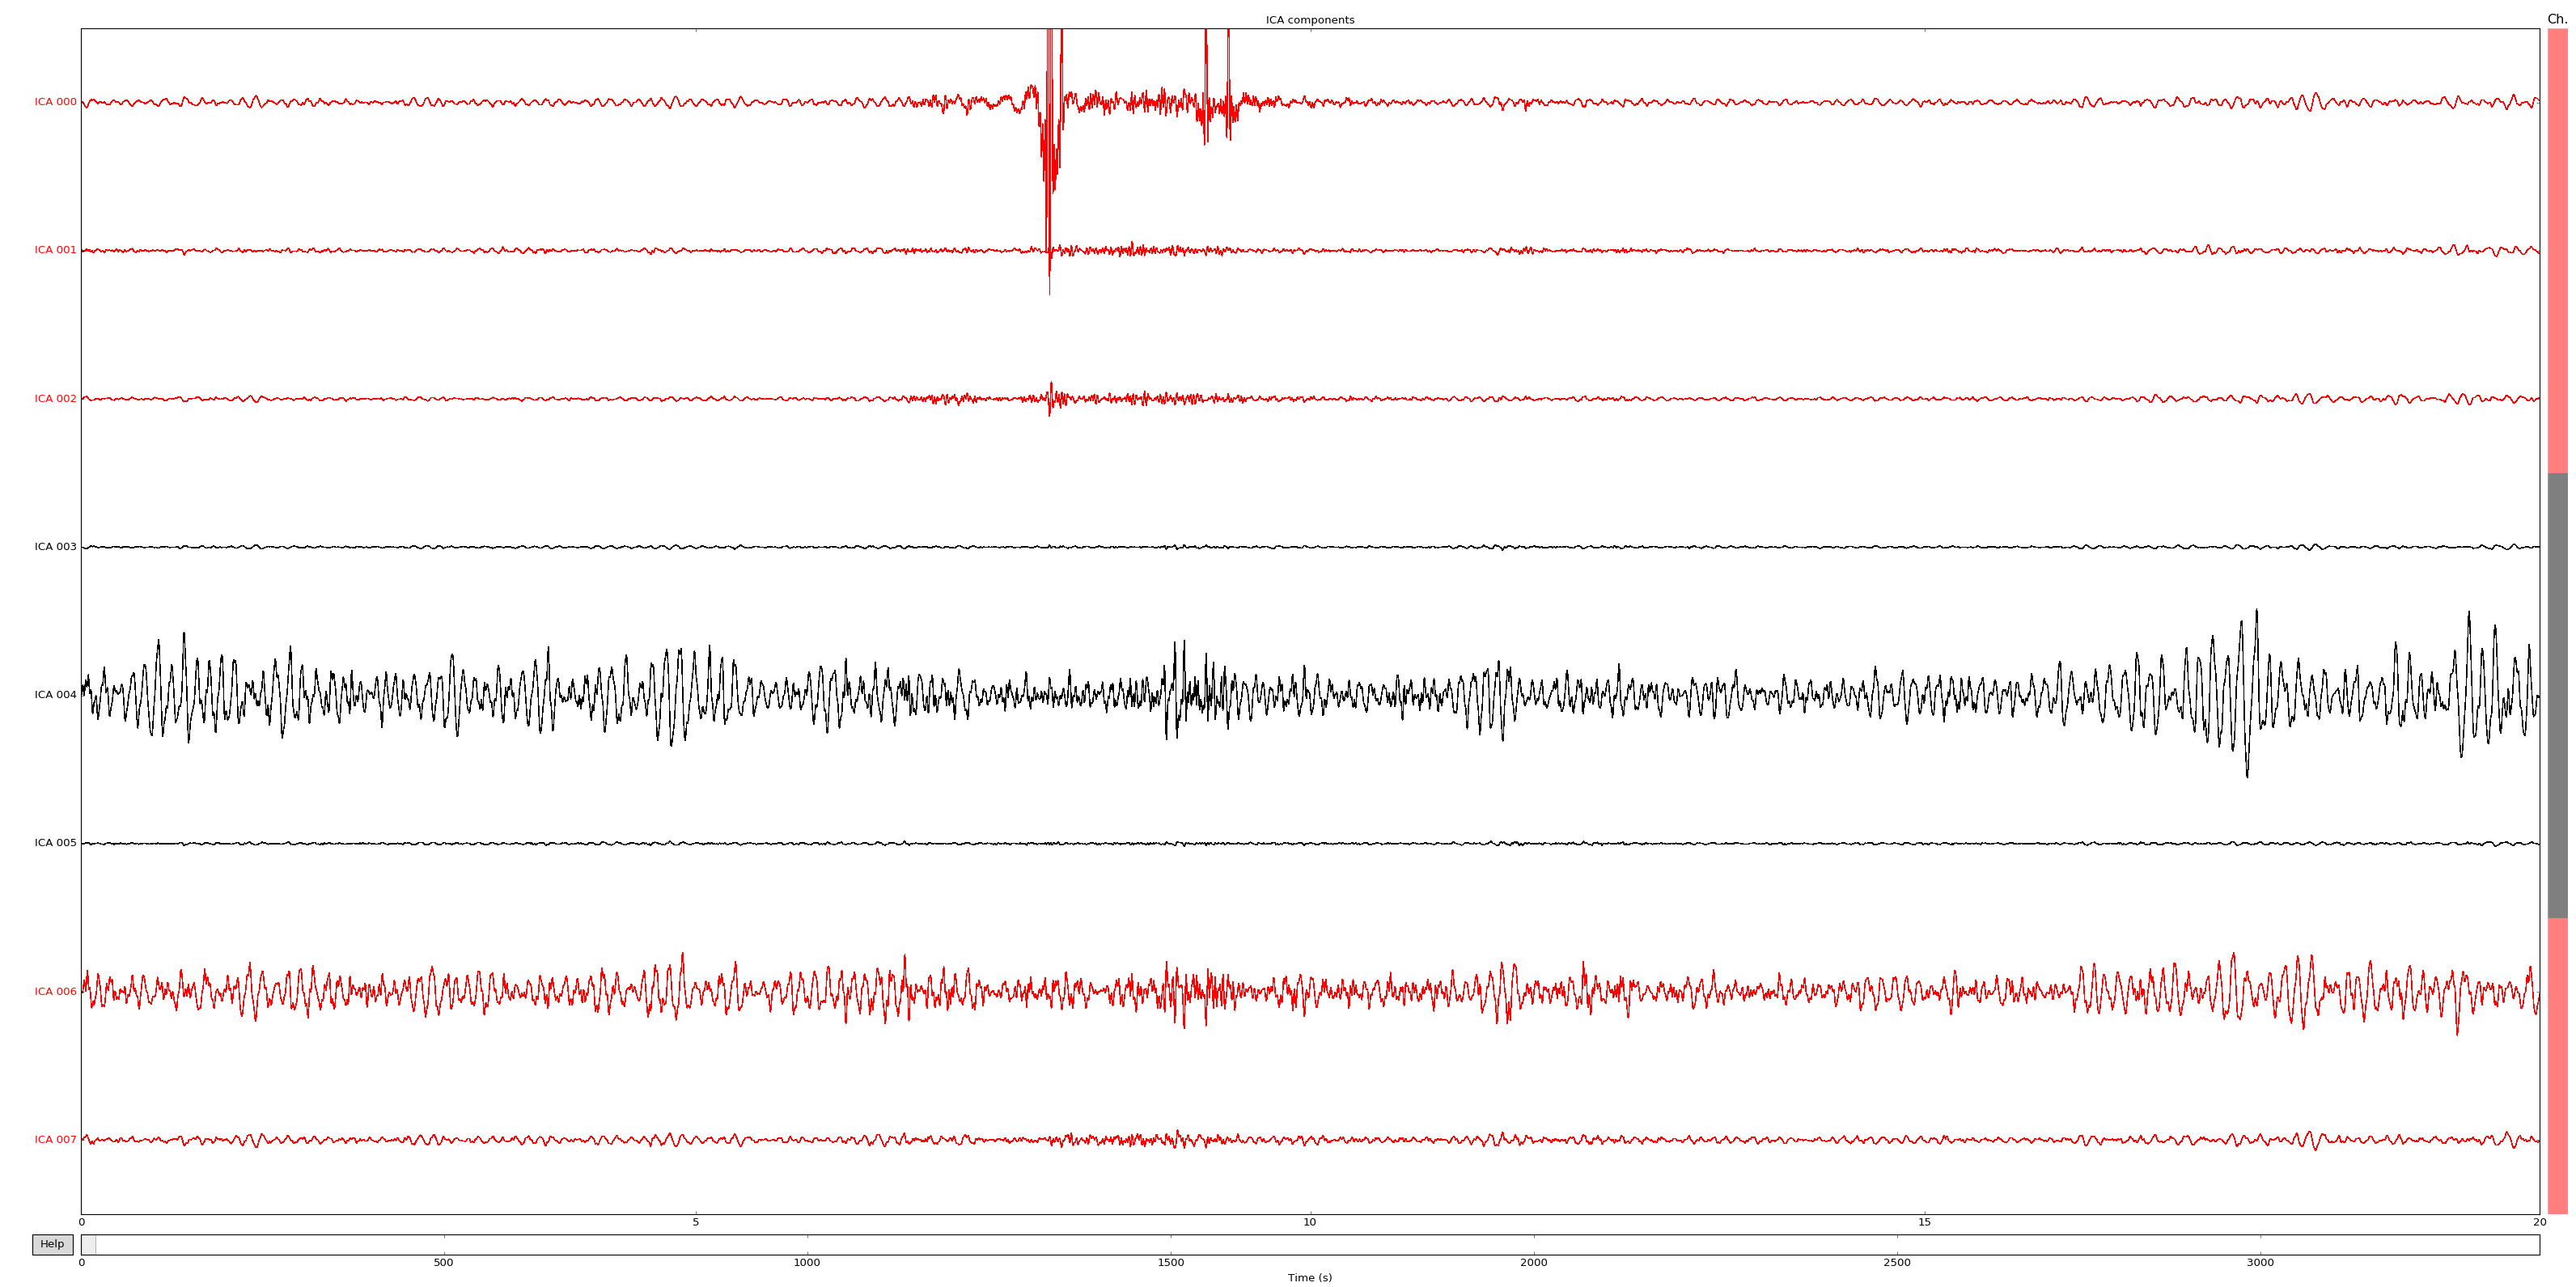

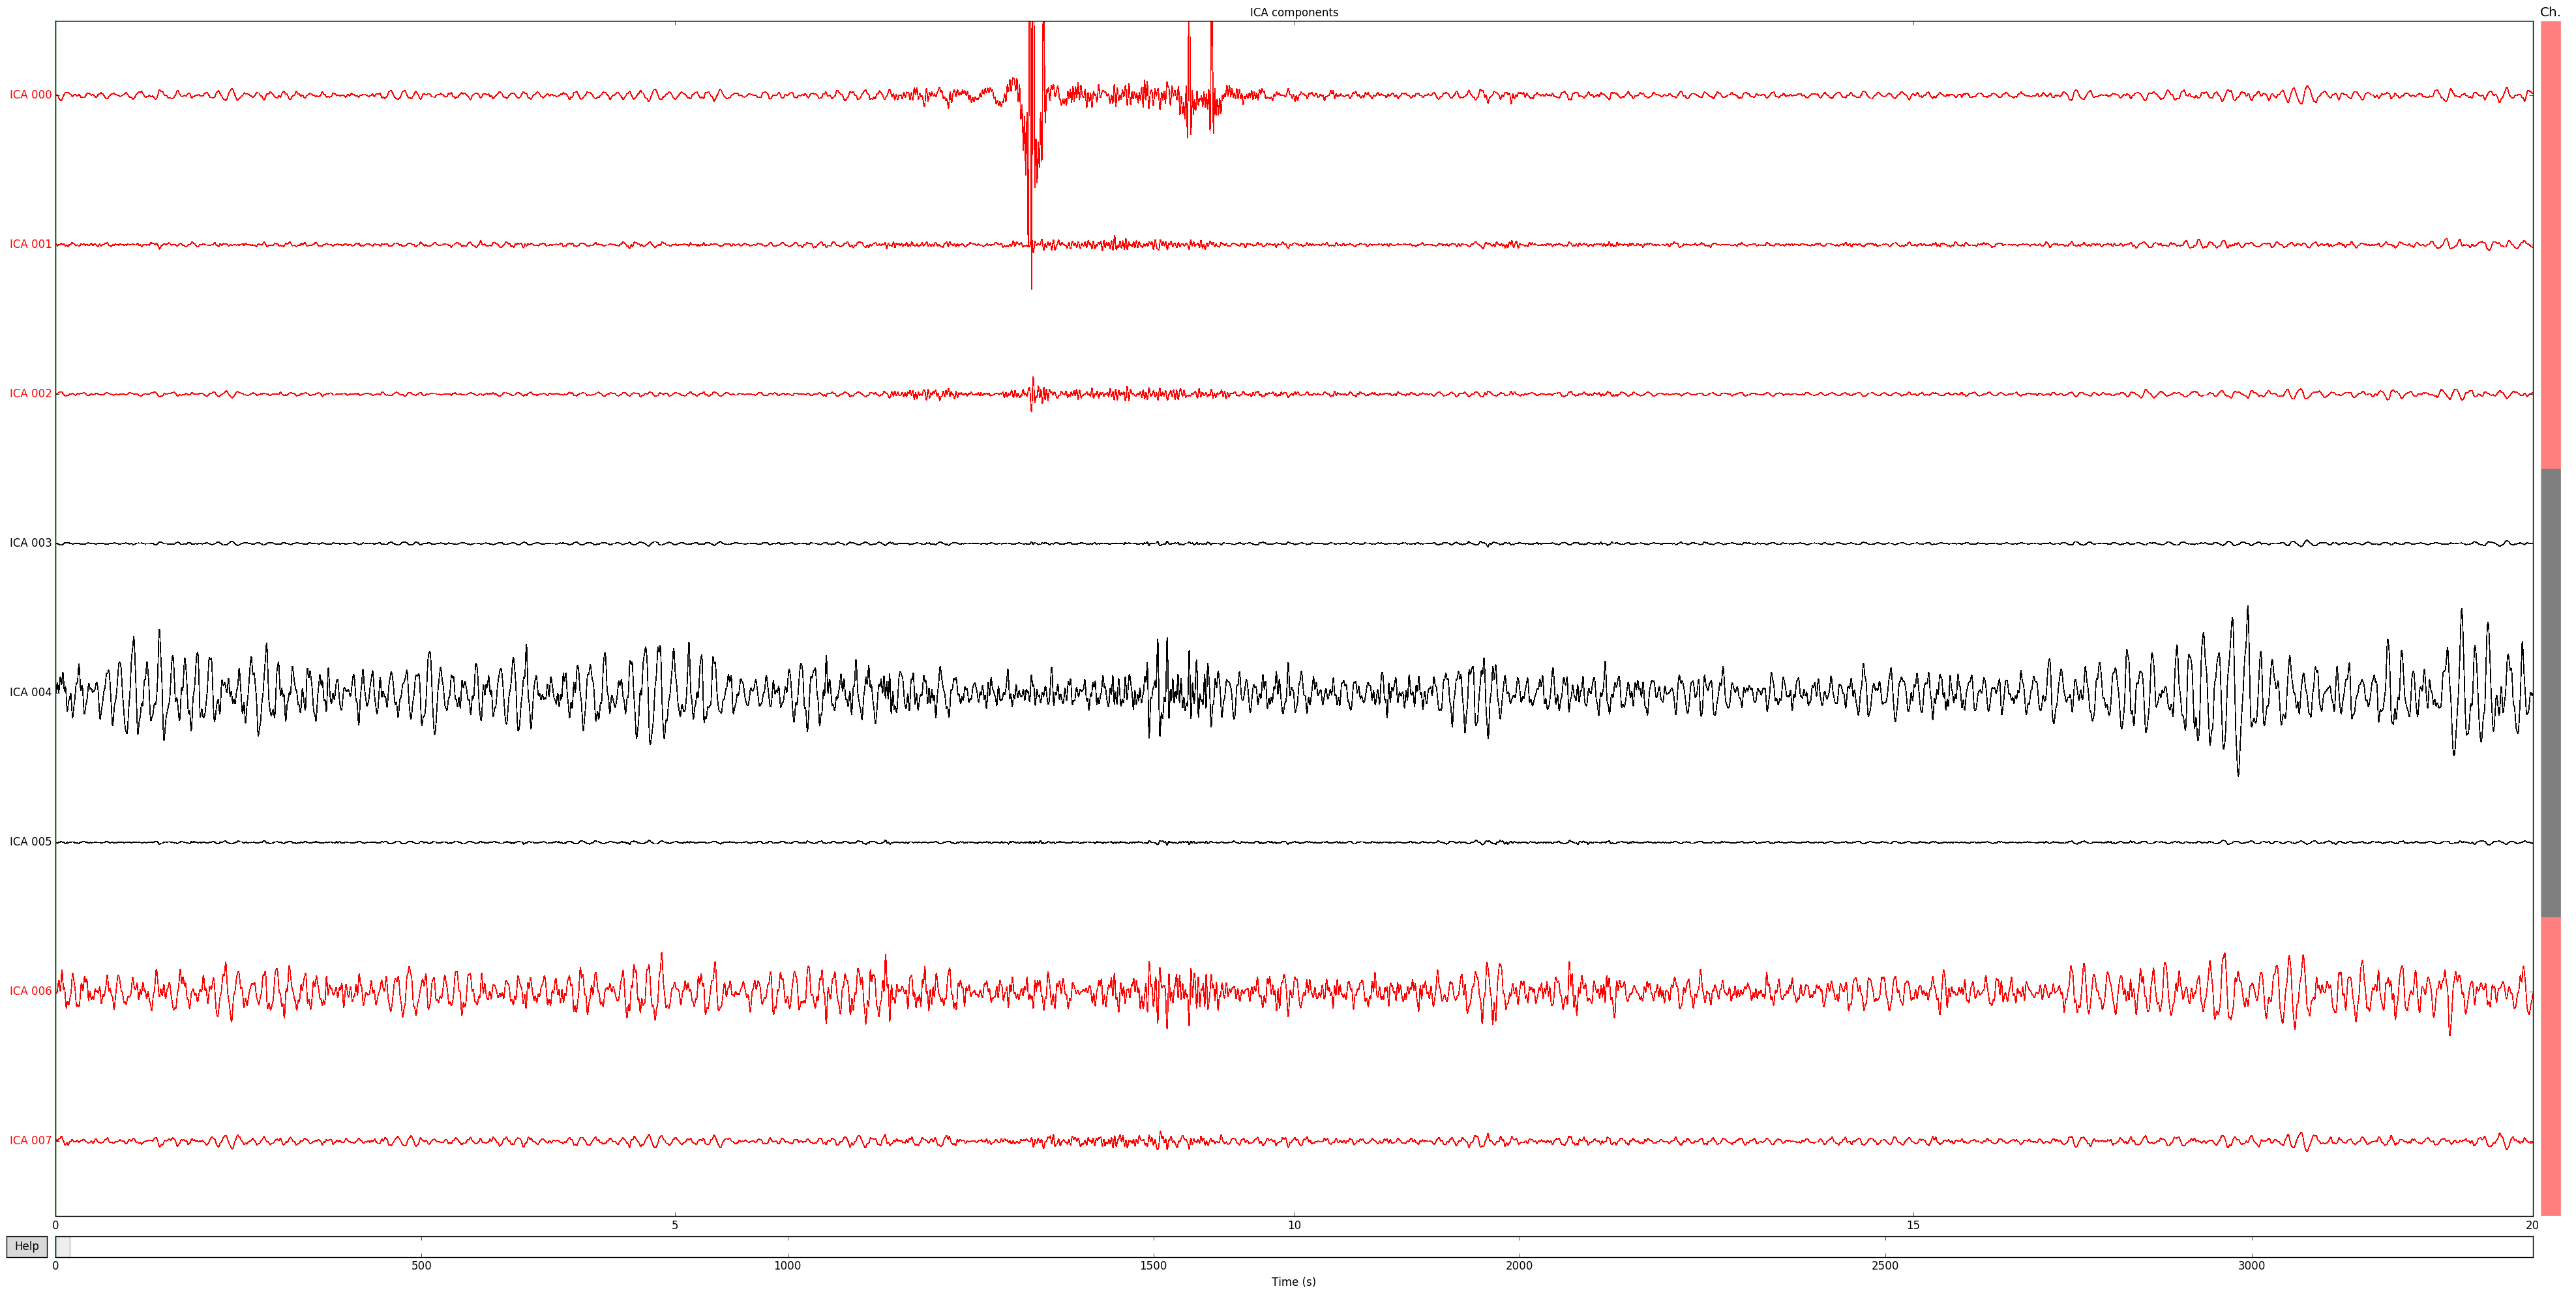

In [24]:
ica.plot_sources(raw,exclude=eog_inds)

<IPython.core.display.Javascript object>


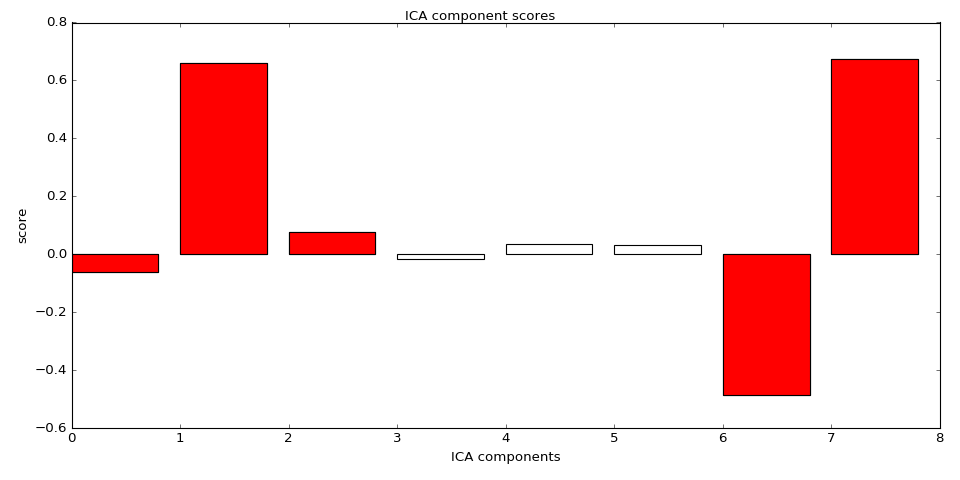

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


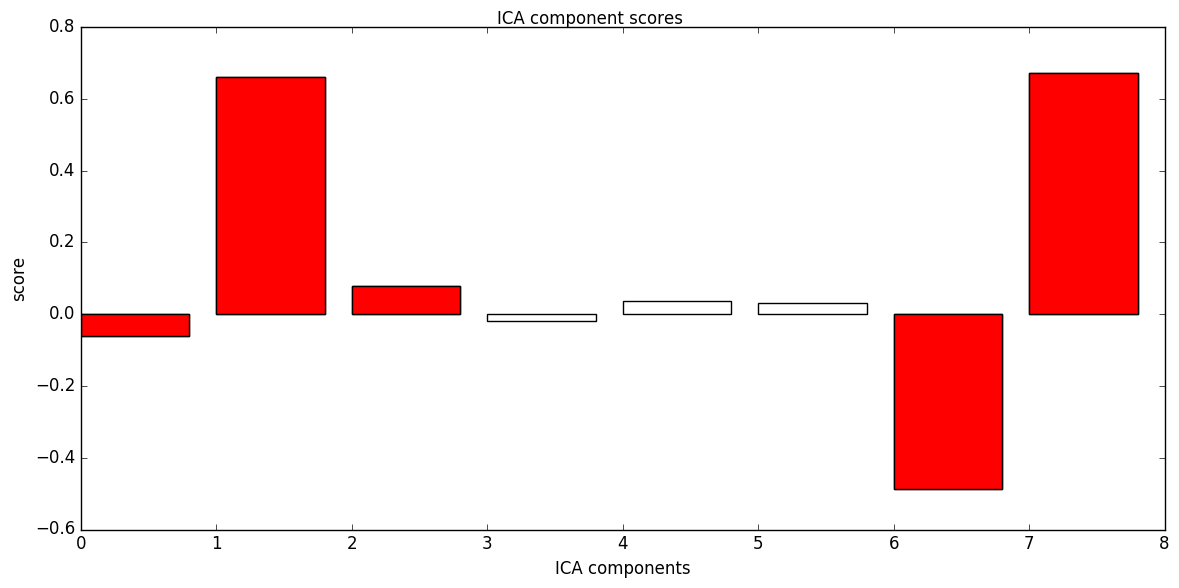

In [25]:
ica.plot_scores(scores,exclude=eog_inds)

Transforming to ICA space (8 components)
Zeroing out 5 ICA components
Inverse transforming to PCA space
Reconstructing sensor space signals from 8 PCA components


<IPython.core.display.Javascript object>


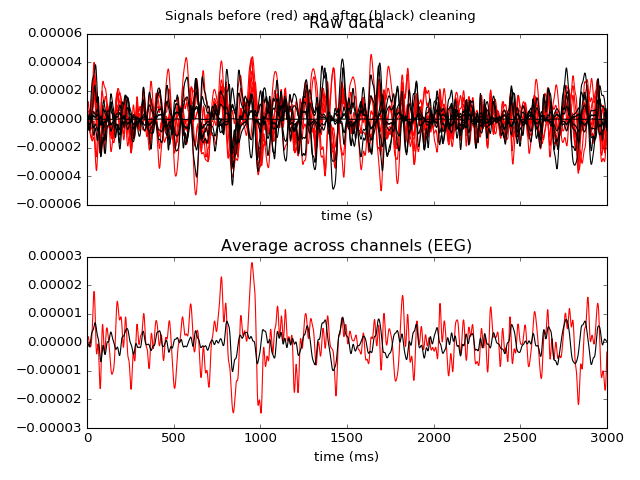

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


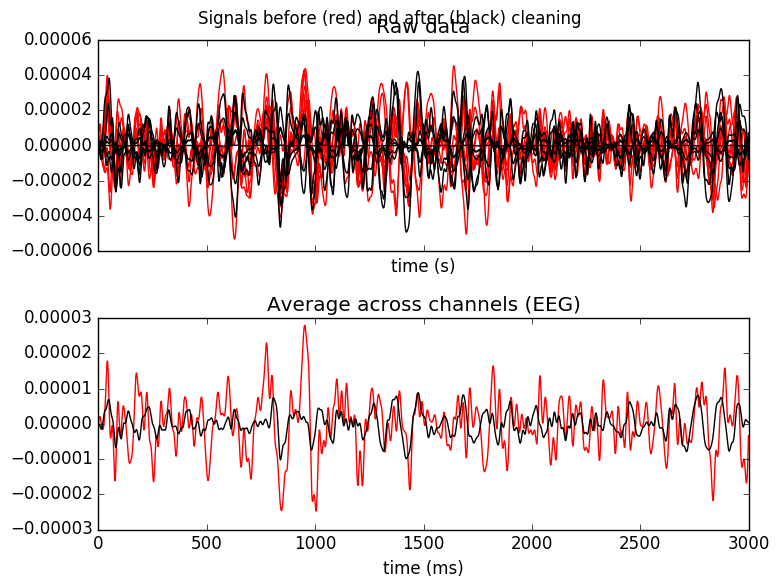

In [27]:
ica.plot_overlay(raw)

In [ ]:
ica.mixing_matrix_

In [ ]:
ica.unmixing_matrix_ 

In [ ]:
start,stop = raw.time_as_index([0,raw.last_samp/1000])
Signal,time=raw[:,start:stop]
Signal.shape

In [ ]:
activity = np.dot(ica.unmixing_matrix_,Signal)
activity.shape
for ii in range(6):
    plt.figure(ii)
    plt.plot(activity[ii,:])

In [ ]:
Winv = np.linalg.inv(ica.unmixing_matrix_)

In [ ]:
raw.plot()

In [ ]:
projection = np.dot(Winv[:,a],activity[a,:])

In [ ]:
for ii in range(6):
    plt.figure(ii)
    plt.plot(Signal[ii,0:30000],label='raw data')
    plt.plot(projection[ii,0:30000],label='corrected data')
    plt.legend()

In [ ]:
ica.info

In [ ]:
ica2=FastICA(n_components=None,whiten=True,max_iter=1000,tol=10e-6)
print(ica2)

In [ ]:
#X=ica2.fit(Signal).transform(Signal)
components = np.dot(ica.unmixing_matrix_.T,Signal)
components.shape

In [ ]:
for ii in range(8):
    
    plt.figure(ii)
    plt.plot(components[ii,500000:2500000])

In [ ]:
clean_signal = np.dot(ica.mixing_matrix_[:,0:3],components[0:3,:])

In [ ]:
for ii in range(8):
    plt.figure(ii)
    plt.subplot(121)
    plt.plot(Signal[ii,:])
    plt.subplot(122)
    plt.plot(clean_signal[ii,:])

In [ ]:
clean_raw = ica.apply(raw,exclude=ica.exclude)

In [ ]:
sample =2
for ii in range(8):
    plt.figure(ii)
    plt.subplot(121)
    plt.plot(raw._data[ii,:],'r')
    plt.title(raw.ch_names[ii])
    plt.subplot(122)
    plt.plot(clean_raw._data[ii,:])
    

In [ ]:
raw.plot()

In [ ]:
clean_raw.plot()